##  Deep Neural Networks Project

In this project, you will be working with a real-world data set from the Las Vegas Metropolitan Police Department. The dataset  contains information about the reported incidents, including the time and location of the crime, type of incident, and number of persons involved.

The dataset is downloaded from the public docket at:
https://opendata-lvmpd.hub.arcgis.com

let's read the csv file and transform the data:

In [438]:
import torch
import pandas as pd
from torch.utils.data import DataLoader, Dataset, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [439]:
  orig_df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'])

In [440]:
df = pd.read_csv('LVMPD-Stats.csv', parse_dates=['ReportedOn'],
                 usecols = ['X', 'Y', 'ReportedOn',
                            'Area_Command','NIBRSOffenseCode',
                            'VictimCount' ] )

df['DayOfWeek'] = df['ReportedOn'].dt.day_name()
df['Time' ]     = df['ReportedOn'].dt.hour
df.drop(columns = 'ReportedOn', inplace=True)

In [441]:

df['X'] = df['X']
df['Y'] = df['Y']
df['Time'] = pd.factorize(df['Time'])[0]
df['DayOfWeek'] = pd.factorize(df['DayOfWeek'])[0]
df.Area_Command = pd.factorize(df['Area_Command'])[0]
df.VictimCount = pd.factorize(df['VictimCount'])[0]
df.NIBRSOffenseCode = pd.factorize(df['NIBRSOffenseCode'])[0]
df.dropna(inplace=True)

In [442]:
df= df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode',
       'DayOfWeek', 'Time','VictimCount']]

In [443]:
df.values.shape

(275, 7)

# Goal
The goal is to build a predictive model that is trained on the following data:
* latitude and longitude (location)
* Hour of the day
* Day of the week
* Area-of-command code: The police designation of the bureau of the operation.
* Classification code for the crime committed
  
The predicted variable is the number of persons involved in the accident.


## Task 1
* print a few rows of the values in the dataframe ``df`` and explain what each column of data means.
* identify the input and target variables
* what is the range of values in each column? Do you need to scale, shift or normalize your data?


In [444]:
print(df.head())
# here, X and Y means latitude and longitude of location of crime
# Area_Command is code for operation for police
# NIBRSOffenseCode is code for type of crime committed
# DayOfWeek day of week when it was reported
# Time is hour when it occurred
# VictimCount is no of victim involved

# as we are trying to predict no of persons involved, the input variables are X, Y, Area_Command, NIBRSOffenseCode, DayOfWeek and Time
# while the target variable is VictimCount

print(df.describe())

# scaling or normalization does not seems necessary for this data.
# they seem ready to use as inputs to a machine learning model as it is

            X          Y  Area_Command  NIBRSOffenseCode  DayOfWeek  Time  \
0 -115.087518  36.216702             0                 0          0     0   
1 -115.240172  36.189693             1                 1          1     1   
2 -115.143088  36.181329             2                 1          2     0   
3 -115.225014  36.117633             3                 1          1     2   
4 -115.176708  36.095967             4                 1          1     3   

   VictimCount  
0            0  
1            0  
2            1  
3            2  
4            0  
                X           Y  Area_Command  NIBRSOffenseCode   DayOfWeek  \
count  275.000000  275.000000    275.000000        275.000000  275.000000   
mean  -115.159326   36.143360      3.978182          0.909091    2.981818   
std      0.101294    0.118418      3.045799          0.334878    1.924590   
min   -116.000000   35.068419      0.000000          0.000000    0.000000   
25%   -115.209198   36.114704      1.000000       

## Task 2

* Create two `DataLoader` objects for training and testing based on the input and output variables. Pick a reasonable batch size and verify the shape of data by iterating over the one dataset and printing the shape of the batched data.

In [445]:
from sklearn.model_selection import train_test_split

# dividing the data into two parts: training and testing sets
X = df[['X', 'Y', 'Area_Command', 'NIBRSOffenseCode', 'DayOfWeek', 'Time']] # independent variable
y = df['VictimCount'] # dependent variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # 20% data will be used for testing and remaining 80% for training

# convert both training and testing data from dataframes to tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

# dataloader for training and testing
# it will load and batch both the data, and each batch sample size will be 32
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# iterate over training dataloader to print shapes to make sure the input and output dimensions matches
for inputs, targets in train_loader:
    print("Batch Input Shape:", inputs.shape)
    print("Batch Target Shape:", targets.shape)
    break


Batch Input Shape: torch.Size([32, 6])
Batch Target Shape: torch.Size([32])


## Task 3
In this task you will try to predict number of crime victims as a **real number**. Therefore the machine learning problem is a **regression** problem.

* Define the proper loss function for this task
* what should the size of the predicted output be?
* explain your choice of architecture, including how many layers you will be using
* define an optimizer for training this model, choose a proper learning rate
* write a training loop that obtains a batch out of the  training data and calculates the forward and backward passes over the neural network. Call the optimizer to update the weights of the neural network.
* write a for loop that continues the training over a number of epochs. At the end of each epoch, calculate the ``MSE`` error on the test data and print it.
* is your model training well? Adjust the learning rate, hidden size of the network, and try different activation functions and number of layers to achieve the best accuracy and report it.

In [446]:
# CrimeVictimPredictorRegression is a feed forward neural network which takes input fetures(data), passes them through several layers with ReLU activation functions and outputs a single value
# hidden_size is number of neurons in each layer
# self.fc1 = nn.Linear(input_size, hidden_size): this is first layer which takes input data(6 features) and produces output with 32 units
# self.relu1 = nn.ReLU(): ReLU is used to introduce non linearity to the model
# similarly, for subsequent layers, hidden layer size decreases and goes deeper into the network. The final layer connects to output layer as it provides output value directly
class CrimeVictimPredictorRegression(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(CrimeVictimPredictorRegression, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(32, 16)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(16, 8)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(8, 4)
        self.relu4 = nn.ReLU()
        self.fc5 = nn.Linear(4, 2)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(2, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(out)
        out = self.relu5(out)
        out = self.fc6(out)
        return out

input_size = 6
hidden_size = 32
output_size = 1
model = CrimeVictimPredictorRegression(input_size, hidden_size, output_size) # an instace variable of our model

# below loss function is basically mean squared error MSE, which measures mean sq. difference between predicted and targer values
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer is used with a learning rate of 0.001

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)


num_epochs = 200

# training loop below iterates over specified number of epochs
for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader: # iterates over training loader. it loads batch of training data everytime
        optimizer.zero_grad()  # it clears gradients gathered from previous batch and resets it
        outputs = model(inputs)  # predicting based on input data: forward pass

        loss = criterion(outputs, targets)  # loss is calculated by comparing the predicted values to the actual values using MSE
        loss.backward()  # backward pass
        optimizer.step()  # adjusting model parameters to minimize loss

    # evaluation of test data after training epoch
    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        for test_inputs, test_targets in test_loader:
            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_targets)

    test_mse = test_loss / len(test_loader)
    print(f'Epoch [{epoch+1}/{num_epochs}] - Test MSE: {test_mse:.4f}')

    # for each batch above, we are using trained model to predict output. After that, average test MSE is calculated which gives us model's overall performance on test data for each epoch

Epoch [1/200] - Test MSE: 1.6500
Epoch [2/200] - Test MSE: 1.6384
Epoch [3/200] - Test MSE: 1.6269
Epoch [4/200] - Test MSE: 1.6156
Epoch [5/200] - Test MSE: 1.6045
Epoch [6/200] - Test MSE: 1.5932
Epoch [7/200] - Test MSE: 1.5824
Epoch [8/200] - Test MSE: 1.5718


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([28])) that is different to the input size (torch.Size([28, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([23])) that is different to the input size (torch.Size([23, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input,

Epoch [9/200] - Test MSE: 1.5608
Epoch [10/200] - Test MSE: 1.5505
Epoch [11/200] - Test MSE: 1.5401
Epoch [12/200] - Test MSE: 1.5293
Epoch [13/200] - Test MSE: 1.5193
Epoch [14/200] - Test MSE: 1.5092
Epoch [15/200] - Test MSE: 1.4994
Epoch [16/200] - Test MSE: 1.4895
Epoch [17/200] - Test MSE: 1.4798
Epoch [18/200] - Test MSE: 1.4700
Epoch [19/200] - Test MSE: 1.4606
Epoch [20/200] - Test MSE: 1.4513
Epoch [21/200] - Test MSE: 1.4421
Epoch [22/200] - Test MSE: 1.4328
Epoch [23/200] - Test MSE: 1.4240
Epoch [24/200] - Test MSE: 1.4150
Epoch [25/200] - Test MSE: 1.4063
Epoch [26/200] - Test MSE: 1.3975
Epoch [27/200] - Test MSE: 1.3891
Epoch [28/200] - Test MSE: 1.3807
Epoch [29/200] - Test MSE: 1.3724
Epoch [30/200] - Test MSE: 1.3641
Epoch [31/200] - Test MSE: 1.3560
Epoch [32/200] - Test MSE: 1.3483
Epoch [33/200] - Test MSE: 1.3403
Epoch [34/200] - Test MSE: 1.3326
Epoch [35/200] - Test MSE: 1.3248
Epoch [36/200] - Test MSE: 1.3173
Epoch [37/200] - Test MSE: 1.3099
Epoch [38/200] 

## Task 4

In this task, you will try to predict the number of crime victims as a **class number**. Therefore the machine learning problem is a **classification** problem.

* Repeat all the steps in task 3. Specifically, pay attention to the differences with regression.
* How would you find the number of classes on the output data?
* How is the architecture different?
* How is the loss function different?
* Calculate the Accuracy for test data as the number of correct classified outputs divided by the total number of test data in each epoch. Report it at the end of each epoch
* Try a few variations of learning rate, hidden dimensions, layers, etc. What is the best accuracy that you can get?

In [447]:
# task 3 is a regression problem to predict number of victims, while task 4 is a classification problem to classify data into multiple classes.
# task 3 has MSE loss function while task 4 has Cross Entropy loss function.

# calculate number of classes in output column to determine number of output classes
num_classes = df['VictimCount'].nunique()

# convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long)

# CrimeVictimClassification consists of several layers with ReLU activation functions
class CrimeVictimClassification(nn.Module):
    def __init__(self, input_dim, num_classes, hidden_dim=128, num_layers=4):
        super(CrimeVictimClassification, self).__init__()  # Corrected call to super()
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, num_classes))
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# an instance variable
input_dim = X_train_tensor.shape[1]
model = CrimeVictimClassification(input_dim, num_classes, num_layers=4)

#loss function computes the cross-entropy loss between the predicted and target class
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Create DataLoader objects for training and testing
batch_size = 64
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# training the model
num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    for inputs, targets in train_loader:
        optimizer.zero_grad() # preventing gradient accumulation
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        test_loss = 0.0
        all_predicted = []
        for test_inputs, test_targets in test_loader:
            test_outputs = model(test_inputs)
            test_loss += criterion(test_outputs, test_targets).item()
            _, predicted = torch.max(test_outputs, 1)
            all_predicted.extend(predicted.numpy())

        test_accuracy = accuracy_score(y_test_tensor, all_predicted)
        print(f'Epoch [{epoch + 1}/{num_epochs}] - Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}')


Epoch [1/50] - Test Loss: 1.0987 - Test Accuracy: 0.5455
Epoch [2/50] - Test Loss: 1.1298 - Test Accuracy: 0.3091
Epoch [3/50] - Test Loss: 1.1258 - Test Accuracy: 0.5455
Epoch [4/50] - Test Loss: 1.1596 - Test Accuracy: 0.3091
Epoch [5/50] - Test Loss: 1.1294 - Test Accuracy: 0.5455
Epoch [6/50] - Test Loss: 1.1048 - Test Accuracy: 0.4909
Epoch [7/50] - Test Loss: 1.1096 - Test Accuracy: 0.5636
Epoch [8/50] - Test Loss: 1.0843 - Test Accuracy: 0.5455
Epoch [9/50] - Test Loss: 1.1113 - Test Accuracy: 0.4909
Epoch [10/50] - Test Loss: 1.0916 - Test Accuracy: 0.5455
Epoch [11/50] - Test Loss: 1.0801 - Test Accuracy: 0.5455
Epoch [12/50] - Test Loss: 1.0744 - Test Accuracy: 0.5455
Epoch [13/50] - Test Loss: 1.0932 - Test Accuracy: 0.5455
Epoch [14/50] - Test Loss: 1.1003 - Test Accuracy: 0.5636
Epoch [15/50] - Test Loss: 1.0856 - Test Accuracy: 0.5636
Epoch [16/50] - Test Loss: 1.0820 - Test Accuracy: 0.5455
Epoch [17/50] - Test Loss: 1.0823 - Test Accuracy: 0.5455
Epoch [18/50] - Test Lo

## Task 5

### Reflect on your results

* Write a paragraph about your experience with tasks 3 and 4. How do you compare the results? Which one worked better? Why?
* Write a piece of code that finds an example of a  miss-classification. Calculate the probabilities for the output classes and plot them in a bar chart. Also, indicate what is the correct class label.

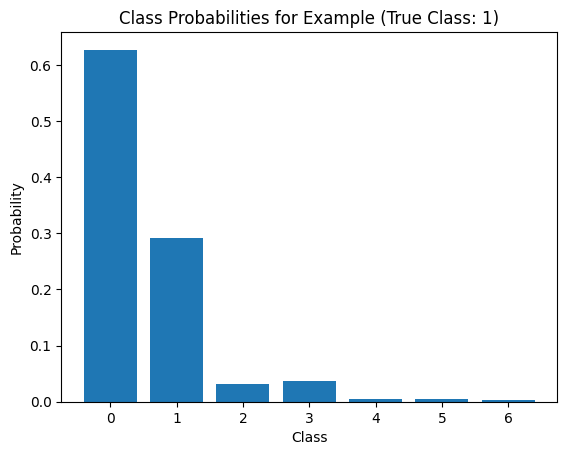

Correct Class: 1
Predicted Class: 0
Highest Probability: 0.6271


In [448]:
# in both the tasks, we have regrssion and classification. Task 3 is aiming for predicting crime victims
# while task 4 categorize data into multiple classes based on crime-related features.
# Task 3's regression model was successful in predicting continuous values, measured by (MSE) on the test data.
# Task 4 usilizes cross entropy loss and clssifies no of victims in categories.
# in summary, the classification model was more effective for predicting victim counts from the crime data.

# setting the model to evaluation mode, it iterates over test data. For each test data, it calculates model's predictions and it visualize using a bar chart.
model.eval()
with torch.no_grad():
    misclassified_example = None
    correct_label = None
    predicted_label = None
    highest_probability = 0.0

    for test_inputs, test_targets in test_loader:
        test_outputs = model(test_inputs)
        _, predicted = torch.max(test_outputs, 1)

        for i in range(len(test_inputs)):
            if predicted[i] != test_targets[i]:
                misclassified_example = test_inputs[i]
                correct_label = test_targets[i]
                predicted_label = predicted[i]
                highest_probability = torch.max(torch.softmax(test_outputs[i], dim=0)).item()
                break
# Plot the class probabilities
classes = list(range(num_classes))

# Use .detach().numpy() to convert the tensor to a NumPy array
probabilities = torch.softmax(model(misclassified_example), dim=0).detach().numpy()

plt.bar(classes, probabilities)
plt.xticks(classes)
plt.xlabel("Class")
plt.ylabel("Probability")
plt.title(f"Class Probabilities for Example (True Class: {correct_label})")
plt.show()

print(f"Correct Class: {correct_label}")
print(f"Predicted Class: {predicted_label}")
print(f"Highest Probability: {highest_probability:.4f}")


## Task 6: Exploring the patterns in raw data

* Plot the crime incidents as a `scatter` plot using the corrdinates. Use the color property of each datapoint to indicate the day of the week. Is there a pattern in the plot?
* Now make a new scatter plot and use the color property of each datapoint to indicate the number of persons involved in the incident. Is there a pattern here?
* use numpy (or pandas if you like) to sort the number of crimes reported by the day of the week. What days are most frequent?


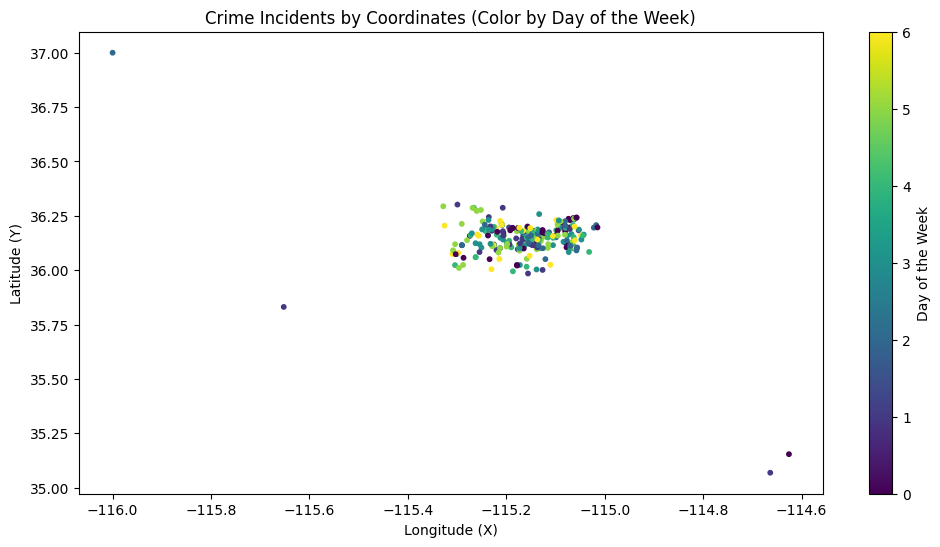

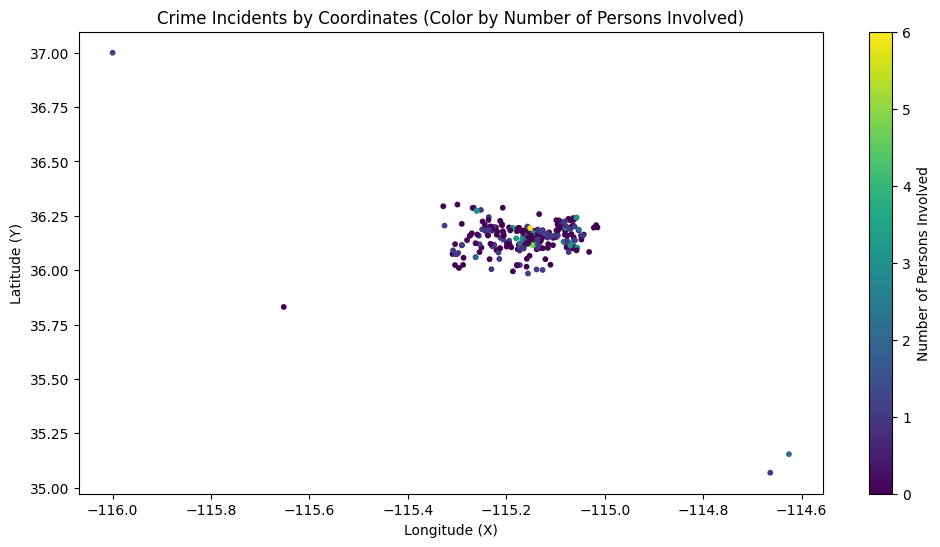

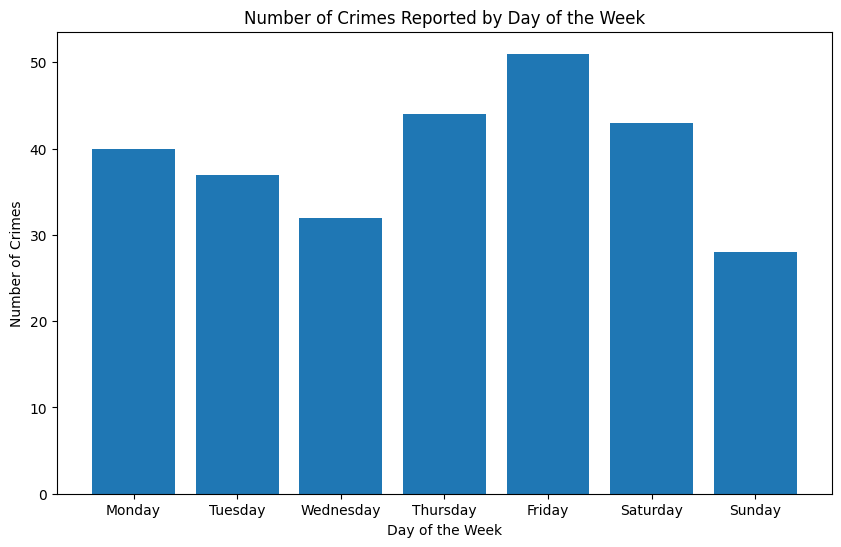

The most frequent day for reporting crimes is Friday.


In [449]:
import matplotlib.pyplot as plt
import numpy as np

# scatter plot with colors indicating the day of the week
# day 3 and day 4 are more observed with crime incidents being taken on those days
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['DayOfWeek'], cmap='viridis', s=10)
plt.colorbar(label='Day of the Week')
plt.title('Crime Incidents by Coordinates (Color by Day of the Week)')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

# scatter plot with colors indicating the number of persons involved
# 3 to 4 victims observed
plt.figure(figsize=(12, 6))
plt.scatter(df['X'], df['Y'], c=df['VictimCount'], cmap='viridis', s=10)
plt.colorbar(label='Number of Persons Involved')
plt.title('Crime Incidents by Coordinates (Color by Number of Persons Involved)')
plt.xlabel('Longitude (X)')
plt.ylabel('Latitude (Y)')
plt.show()

# number of crimes reported by each day of the week
day_of_week_counts = df['DayOfWeek'].value_counts().sort_index()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# number of crimes by day of the week
plt.figure(figsize=(10, 6))
plt.bar(days, day_of_week_counts)
plt.title('Number of Crimes Reported by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Crimes')
plt.show()

# most frequent day of the week
most_frequent_day = days[day_of_week_counts.idxmax()]
print(f'The most frequent day for reporting crimes is {most_frequent_day}.')
